In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),                # Flatten the input, so in this example an image of (1x28x28) to a 1D vector of size 784
            nn.Linear(784, latent_dim),  # A fully connected (dense) layer that maps the 784 vector input to latent_dim (default is 64)
            nn.ReLU()                    # ReLU Activation function for non-linearity. It activates only positive values and sets negative values to 0
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 784),  # A fully connected (dense) layer that maps the latent representation (default 64) to 784 (flattened image)
            nn.Sigmoid(),                # Sigmoid activation function so that output values are squashed between 0 and 1
            nn.Unflatten(1, (1, 28, 28)) # Reshape the output into a 1x28x28 image
        )

    def forward(self, x):
        encoded = self.encoder(x)        # Pass the input through the encoder
        decoded = self.decoder(encoded)  # Pass the encoded representation through the decoder
        return decoded                   # return the reconstructed output


# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch_features, _ in train_loader:
        # Move batch to device
        batch_features = batch_features.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Compute reconstructions
        outputs = model(batch_features)

        # Compute training reconstruction loss
        loss = criterion(outputs, batch_features)

        # Compute gradients
        loss.backward()

        # Adjust model weights
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [62]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Load Fashion MNIST dataset using torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


# Create DataLoaders
_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [63]:
# Initialize the model
_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_model = Autoencoder().to(_device)

# Loss and optimizer
_criterion = nn.MSELoss()
_optimizer = optim.Adam(_model.parameters() )



In [64]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(_model, _train_loader, _criterion, _optimizer, _device)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}')


Epoch [1/10], Loss: 0.0378
Epoch [2/10], Loss: 0.0136
Epoch [3/10], Loss: 0.0090
Epoch [4/10], Loss: 0.0076
Epoch [5/10], Loss: 0.0070
Epoch [6/10], Loss: 0.0067
Epoch [7/10], Loss: 0.0066
Epoch [8/10], Loss: 0.0065
Epoch [9/10], Loss: 0.0064
Epoch [10/10], Loss: 0.0064


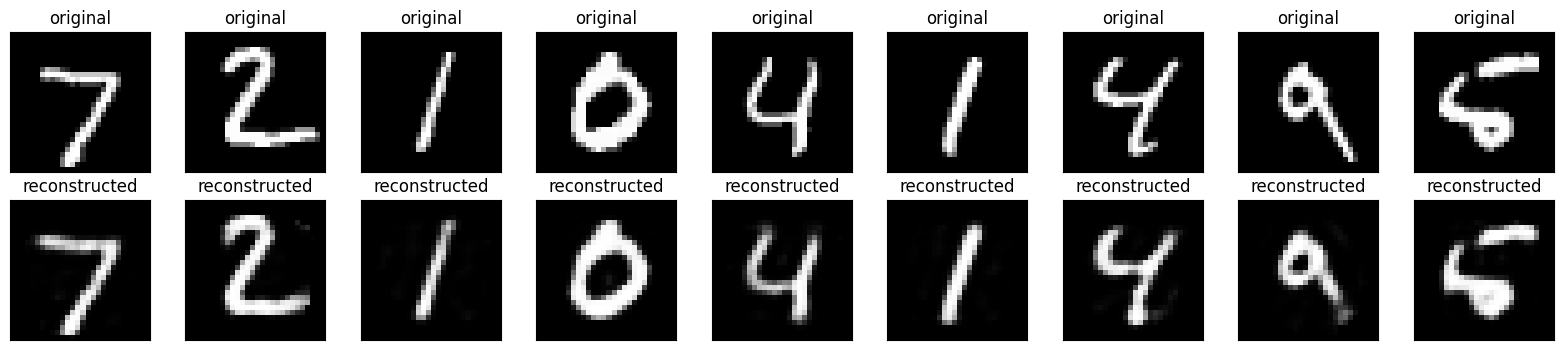

In [84]:
# Visualize results
_model.eval()
with torch.no_grad():
    # Get first batch from test loader
    test_images, _ = next(iter(_test_loader))
    test_images = test_images.to(_device)

    # Reconstruct images
    reconstructed_images = _model(test_images)

    # Prepare images for plotting
    test_images = test_images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    import random
    # Plot original and reconstructed images

    n = 9
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_images[i].squeeze().numpy(), cmap='gray')
        plt.title("original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].squeeze().numpy(), cmap='gray')
        plt.title("reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [56]:
torch.save(_model.state_dict(), "autoencoder.pt")